# **Configuracion de la simulacion**

Ponerse en la carpeta raiz

In [1]:
import os

current_folder = os.path.basename(os.getcwd())
if current_folder == "optimizaciones":
    os.chdir("..")
    print(os.getcwd())
else:
    print("Ya estás en la carpeta TRABAJO-DOM")

c:\Users\pablomaga\Documents\GitHub\Trabajo-DOM


Importar librerias

In [2]:
#### IMPORTAR LIBRERIAS ####
from src.models.car import Car # Modelo del coche
from src.models.track import Track # Modelo de la pista
from src.models.aero import Aero
from src.simulator.lap_simulator import LapSimulator # Simulador de vuelta

# Librerias para graficar
import matplotlib.pyplot as plt

# **Configuracion de la optimización**

Estos parámetros son ***FIJOS***. Iniciad siempre los modelos de ```Car``` y ```Aero``` con esto

In [3]:
mass = 800               # kg, masa típica de un F1 en carrera
tire_grip = 1.7          # coeficiente de agarre elevado para neumáticos especializados
power = 600000           # W, potencia equivalente a unos 1000 CV aproximadamente
brake_force = 45000     # N, fuerza de frenado potente

fw_area = 1.8            # m², área del ala frontal
rw_area = 1.3            # m², área del ala trasera

cl_alpha_front = 0.25     # incremento de coeficiente de downforce por grado del ala frontal
cl_alpha_rear = 0.3      # incremento de coeficiente de downforce por grado del ala trasera
cd_alpha_front = 0.08     # incremento de coeficiente de resistencia aerodinámica del ala frontal
cd_alpha_rear = 0.06     # incremento de coeficiente de resistencia aerodinámica del ala trasera

brake_bias = 0.6          # distribución de frenado entre el eje delantero y trasero
wheelbase = 3.0            # m, distancia entre ejes
h_cg = 0.3                 # m, altura del centro de gravedad

Construimos el objeto de ```Aero```

In [4]:
aero = Aero(cl_alpha_front = cl_alpha_front, 
            cl_alpha_rear = cl_alpha_rear, 
            cd_alpha_front = cd_alpha_front, 
            cd_alpha_rear = cd_alpha_rear, 
            fw_area = fw_area, 
            rw_area = rw_area,
        )

***Definimos los ángulos de ataque de los alerones, que son una de las cosas mas importantes en la optimizacion***

In [5]:
aero.aoa_front = 7
aero.aoa_rear = 5

Creamos el coche

In [6]:
car = Car(mass = mass, 
          tire_grip = tire_grip, 
          power = power, 
          brake_force = brake_force, 
          aero = aero,
          brake_bias = brake_bias,
          wheelbase = wheelbase,
          h_cg = h_cg,
        )

Cargamos el circuito

In [7]:
track = Track.from_json("track.json")

Y finalmente creamos el simulador

In [8]:
simulator = LapSimulator(car, track)

***ESTO QUE HE HECHO HASTA AHORA NO LO TENEIS QUE CAMBIAR, HACEDLO SIEMPRE ASÍ (salvo que queráis modificar alguno de los parámetros fijos por algún motivo)***

# ***PRIMERA OPTIMIZACION: Solo un alerón***

Dejas fijo todos los parametros, y solo optimizas el angulo del aleron delantero. La funcion es la siguiente

In [9]:
# La funcion seria esta
def f1(aoa_front):
    aero.aoa_front = aoa_front[0]
    lap_time, _ = simulator.simulate_lap()
    return lap_time

In [10]:
from scipy.optimize import minimize

# Definimos un valor inicial para el ángulo del alerón delantero
aoa_front_init = 8

# Realizamos la optimización
result = minimize(f1, x0=aoa_front_init, bounds=[(0, 18)], method='L-BFGS-B')  # Puedes cambiar 'L-BFGS-B' por otro algoritmo como 'TNC', 'Powell', etc.

print("Ángulo óptimo del alerón delantero:", result.x[0])
print("Tiempo de vuelta mínimo:", result.fun)

c:\Users\pablomaga\Documents\GitHub\Trabajo-DOM\src\models\car.py:110: RuntimeWarning: overflow encountered in scalar multiply
  vmax = (grip_force * radius / self.mass) ** 0.5


Ángulo óptimo del alerón delantero: 2.2694299258096318
Tiempo de vuelta mínimo: 92.47180585844826


Cosas para cambiar:
- Probar varios methodos (parámetro ```method```. preguntarle a chatgpt)
- Cambiar parámetros arriba (rollo ver cómo afecta la masa, etc)
- Cambiar el circuito
- Cambiar la condición inicial (en este caso, se va a ver que no afecta cambiar la condición inicial porque es un problema convexo)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


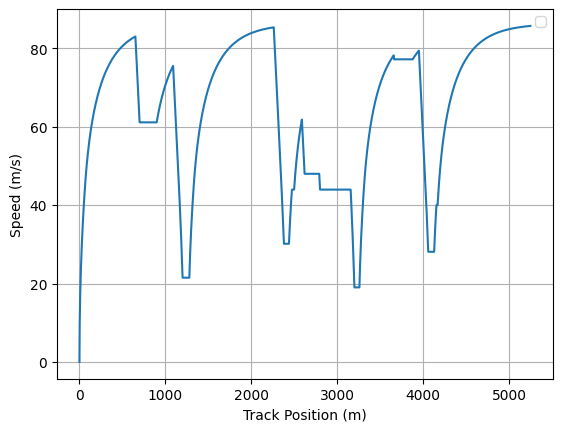

In [11]:
simulator.plot_lap()
plt.show()

# ***SEGUNDA OPTIMIZACION: Ambos alerones + brake bias***

Ahora, la funcion a optimizar es la siguiente

In [12]:
def f2(x):
    """
    x es un vector de 3 elementos
    x[0] = aoa_front
    x[1] = aoa_rear
    x[2] = brake_bias
    x[3] = fw_area
    x[4] = rw_area
    """
    
    aoa_front = x[0]
    aoa_rear = x[1]
    brake_bias = x[2]
    fw_area = x[3]
    rw_area = x[4]

    aero.aoa_front = aoa_front
    aero.aoa_rear = aoa_rear
    car.brake_bias = brake_bias
    aero.fw_area = fw_area
    aero.rw_area = rw_area
    
    lap_time, _ = simulator.simulate_lap()
    return lap_time

In [13]:
print(aero.aoa_front)

2.2694299358096317


In [14]:
# Valores iniciales para aoa_front, aoa_rear y brake_bias
# Valores iniciales para aoa_front, aoa_rear y brake_bias
aoa_front_init = 10    # Ángulo inicial del alerón delantero
aoa_rear_init = 1     # Ángulo inicial del alerón trasero
brake_bias_init = 0.5 # Valor inicial de brake bias
fw_area = 1.4
rw_area = 1.4

x0 = [aoa_front_init, aoa_rear_init, brake_bias_init, fw_area, rw_area]

# Definimos los límites para cada variable
bounds = [(1, 18),   # aoa_front
          (1, 18),   # aoa_rear
          (0.3, 0.7), # brake_bias 
          (0.5, 2),  # fw_area 
          (0.5, 1.5)   # rw_area 
         ]

# Realizamos la optimización
result2 = minimize(f2, x0=x0, bounds=bounds)

print("Ángulo óptimo del alerón delantero:", result2.x[0])
print("Ángulo óptimo del alerón trasero:", result2.x[1])
print("Brake bias óptimo:", result2.x[2])
print("Tiempo de vuelta mínimo:", result2.fun)
print("Área frontal óptima:", result2.x[3])
print("Área trasera óptima:", result2.x[4])

Ángulo óptimo del alerón delantero: 2.1439335179995607
Ángulo óptimo del alerón trasero: 4.437232982160598
Brake bias óptimo: 0.6699946058920168
Tiempo de vuelta mínimo: 91.60061554842592
Área frontal óptima: 2.0
Área trasera óptima: 1.5


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


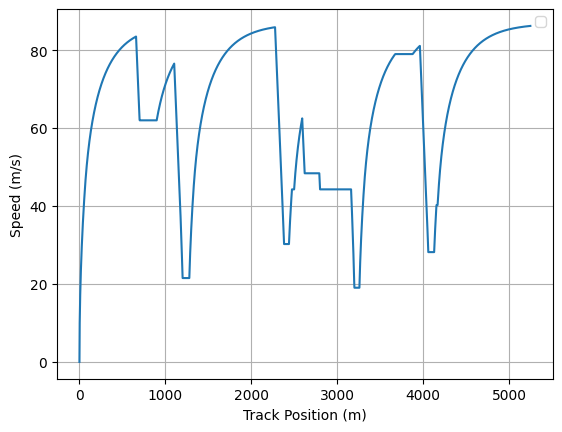

In [15]:
simulator.plot_lap()
plt.show()